# LABORATORY SESSION - WEEK 12

## Understanding The Articles 

- What types of trolls are there in the database?
    - normal american citizens (comments on real time events)
    - local news outlets (violence)
    - local political party (republican)
- How to tell them apart?
    - community detection algorithm
- What do trolls do?
    - rigth wing (positive tweets)
    - left wing (negative tweets)
    - black lives matter community
- What hashtags they used?
    - ashtags

In [15]:
# import 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import datetime
import random

### Problem 1 

Import tweeter data. Draw networks illustrating the relationships inside them. 

### Solution 

In [11]:
# Data file paths
tweets_dir = "data/tweets.csv"
users_dir = "data/users.csv"

# Load datasets using pandas
tweets_df = pd.read_csv(tweets_dir)
users_df = pd.read_csv(users_dir)

# Display the first few rows of each dataset
print("Tweets Dataset:")
print(tweets_df.head())

print("\nUsers Dataset:")
print(users_df.head())

# Compute and display the number of rows and columns for each dataset
print("\nTweets Dataset Dimensions:")
print(f"Rows: {tweets_df.shape[0]}, Columns: {tweets_df.shape[1]}")

print("\nUsers Dataset Dimensions:")
print(f"Rows: {users_df.shape[0]}, Columns: {users_df.shape[1]}")

# Display additional descriptive statistics
print("\nTweets Dataset Description:")
print(tweets_df.describe(include='all'))

print("\nUsers Dataset Description:")
print(users_df.describe(include='all'))

Tweets Dataset:
        user_id         user_key    created_at          created_str  \
0  2.532612e+09        kathiemrr  1.488207e+12  2017-02-27 14:54:00   
1  2.531160e+09   traceyhappymom  1.471273e+12  2016-08-15 14:50:20   
2           NaN    evewebster373  1.435701e+12  2015-06-30 21:56:09   
3  4.840552e+09      blacktolive  1.474013e+12  2016-09-16 08:04:48   
4  1.694026e+09  jacquelinisbest  1.474228e+12  2016-09-18 19:46:25   

   retweet_count retweeted  favorite_count  \
0            NaN       NaN             NaN   
1            NaN       NaN             NaN   
2            NaN       NaN             NaN   
3           18.0     False            17.0   
4            0.0     False             0.0   

                                                text      tweet_id  \
0    #ThingsDoneByMistake kissing auntie in the lips  8.362279e+17   
1  RT @mc_derpin: #TheOlderWeGet the more pessimi...  7.651989e+17   
2  RT @dmataconis: Ready To Feel Like A Failure? ...  6.160023e+17   


In [12]:
# Helper function to preprocess and clean data
def preprocess_data(tweets, users):
    # Convert timestamps to datetime objects
    tweets['created_at'] = pd.to_datetime(tweets['created_at'], errors='coerce')
    # Fill missing values in mentions and hashtags with empty lists
    tweets['mentions'] = tweets['mentions'].apply(lambda x: eval(x) if pd.notnull(x) else [])
    tweets['hashtags'] = tweets['hashtags'].apply(lambda x: eval(x) if pd.notnull(x) else [])
    return tweets, users

tweets_df, users_df = preprocess_data(tweets_df, users_df)

In [20]:
def create_twitter_network(users_df, tweets_df):
    """
    Creates an undirected graph representing a Twitter troll network based on users and tweets datasets.
    
    Parameters:
        users_df (pd.DataFrame): DataFrame containing user data with columns ['id', 'name', 'location'].
        tweets_df (pd.DataFrame): DataFrame containing tweet data with columns ['user_id', 'mentions', 'retweeted_status_id', 'tweet_id'].
    
    Returns:
        nx.Graph: Undirected graph with nodes as users and edges representing interactions.
    """
    # Create an undirected graph
    G = nx.Graph()
    
    # Add nodes (users)
    def add_nodes():
        for _, user in users_df.iterrows():
            G.add_node(user['id'], name=user['name'], location=user['location'])
    
    # Add edges (interactions)
    def add_edges():
        for _, tweet in tweets_df.iterrows():
            user_id = tweet['user_id']
            
            # Mentions
            for mentioned_user in tweet['mentions']:
                G.add_edge(user_id, mentioned_user, interaction='mention', tweet_id=tweet['tweet_id'])
            
            # Retweets
            if pd.notnull(tweet['retweeted_status_id']):
                original_tweet_id = tweet['retweeted_status_id']
                original_user = tweets_df.loc[tweets_df['tweet_id'] == original_tweet_id, 'user_id'].values
                if original_user.size > 0:
                    G.add_edge(user_id, original_user[0], interaction='retweet', tweet_id=tweet['tweet_id'])
    
    # Build the graph
    add_nodes()
    add_edges()
    
    return G

# Example usage
G = create_twitter_network(users_df, tweets_df)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 14404 nodes and 33834 edges.


In [22]:
# Basic graph descriptions
print("Graph Description:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Node and edge attributes
print("\nSample Node Attributes:")
print(list(G.nodes(data=True))[:5])  # Display first 5 nodes with attributes

print("\nSample Edge Attributes:")
print(list(G.edges(data=True))[:5])  # Display first 5 edges with attributes

# Density of the graph
density = nx.density(G)
print(f"\nGraph Density: {density:.4f}")

# Degree statistics
degrees = [deg for _, deg in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)
avg_degree = sum(degrees) / len(degrees)
print(f"\nDegree Statistics:")
print(f"Max Degree: {max_degree}")
print(f"Min Degree: {min_degree}")
print(f"Average Degree: {avg_degree:.2f}")

# Clustering coefficient
clustering_coeff = nx.average_clustering(G)
print(f"\nAverage Clustering Coefficient: {clustering_coeff:.4f}")

# Centrality measures
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 Nodes by Degree Centrality:")
for node, centrality in top_degree_centrality:
    print(f"Node {node}: Centrality {centrality:.4f}")

Graph Description:
Number of nodes: 14404
Number of edges: 33834

Sample Node Attributes:
[(100345056.0, {'name': '#Ezekiel2517✨...', 'location': 'still ⬆️Block⤵️Corner⬇️street'}), (247165706.0, {'name': 'B E C K S T E R✨', 'location': 'Chicago, IL'}), (249538861.0, {'name': 'Chris Osborne', 'location': nan}), (449689677.0, {'name': 'Рамзан Кадыров', 'location': nan}), (471868887.0, {'name': 'Маргарита Саваж', 'location': 'Санкт-Петербург, Россия'})]

Sample Edge Attributes:
[(100345056.0, 'realdonaldtrump', {'interaction': 'mention', 'tweet_id': 7.848221218181857e+17}), (100345056.0, 'uniqueloves', {'interaction': 'mention', 'tweet_id': 7.867756587310203e+17}), (100345056.0, 'kokopellient', {'interaction': 'mention', 'tweet_id': 7.818447885092864e+17}), (100345056.0, 'realdlhughley', {'interaction': 'mention', 'tweet_id': 7.818447885092864e+17}), (100345056.0, 'zakeyamasada', {'interaction': 'mention', 'tweet_id': 7.818447885092864e+17})]

Graph Density: 0.0003

Degree Statistics:
Max

In [29]:
def reduce_graph(graph, fraction=0.1):
    """
    Reduces a graph by sampling a fraction of nodes and their associated edges.
    
    Parameters:
        graph (nx.DiGraph): Original graph.
        fraction (float): Fraction of nodes to retain (0 < fraction ≤ 1).
    
    Returns:
        nx.DiGraph: Reduced graph.
    """
    # Sample nodes
    sampled_nodes = random.sample(graph.nodes(), int(len(graph) * fraction))
    
    # Create subgraph with sampled nodes
    reduced_graph = graph.subgraph(sampled_nodes).copy()
    
    return reduced_graph

# Example usage
reduced_network = reduce_graph(G, fraction=0.3)
print(f"Reduced graph with {reduced_network.number_of_nodes()} nodes and {reduced_network.number_of_edges()} edges.")

Reduced graph with 4321 nodes and 2727 edges.


C:\Users\39392\AppData\Local\Temp\ipykernel_12060\1599271969.py:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph.nodes(), int(len(graph) * fraction))


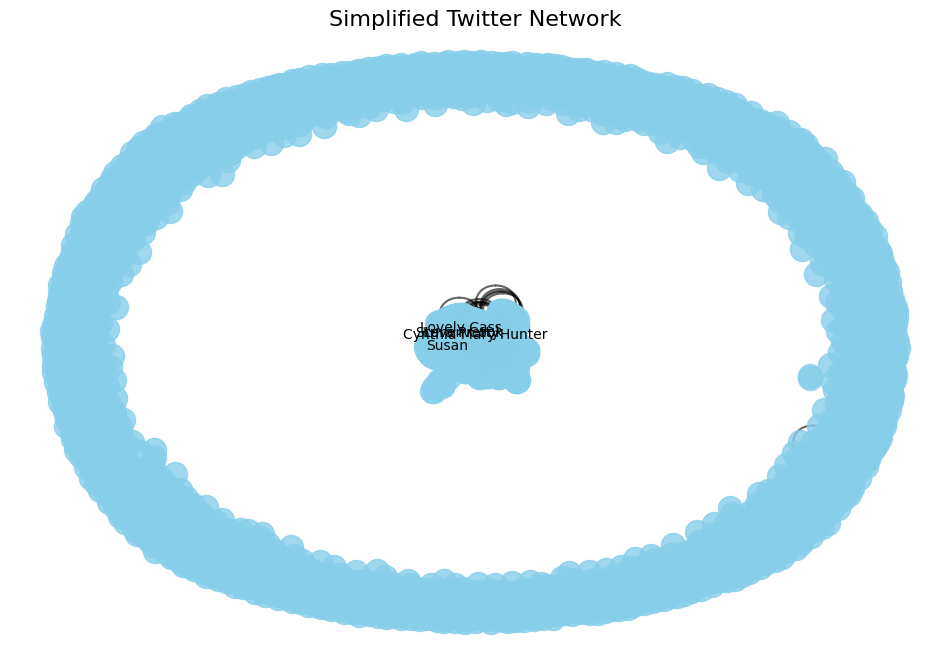

In [30]:
def visualize_network(graph, title="Twitter Network"):
    """
    Visualizes the given graph with a simple and clear layout.
    
    Parameters:
        graph (nx.Graph): The NetworkX graph to visualize.
        title (str): Title for the plot.
    """
    # Use spring layout for positioning
    pos = nx.spring_layout(graph, seed=42)  # Seed for consistent layout

    # Set a uniform node size and edge width for simplicity
    node_size = 300
    edge_width = 1.5
    
    # Draw the graph
    plt.figure(figsize=(12, 8))
    plt.axis('off')  # Turn off axes

    # Draw nodes
    nx.draw_networkx_nodes(
        graph, pos,
        node_size=node_size,
        node_color='skyblue',
        alpha=0.8
    )

    # Draw edges
    nx.draw_networkx_edges(
        graph, pos,
        width=edge_width,
        alpha=0.6
    )

    # Add labels for a small subset of nodes (e.g., top 5 by degree)
    top_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:5]
    nx.draw_networkx_labels(
        graph, pos,
        labels={node: graph.nodes[node].get('name', node) for node, _ in top_nodes},
        font_size=10
    )

    # Add a title
    plt.title(title, fontsize=16)
    plt.show()

# Example Usage
visualize_network(reduced_network, title="Simplified Twitter Network")


In [27]:
# Network Analysis
def analyze_network(graph):
    metrics = {
        "density": nx.density(graph),
        "clustering_coefficient": nx.average_clustering(graph),
        "degree_centrality": nx.degree_centrality(graph),
        "betweenness_centrality": nx.betweenness_centrality(graph),
        "eigenvector_centrality": nx.eigenvector_centrality(graph, max_iter=1000),
    }
    return metrics

analysis_metrics = analyze_network(G)
print("Network Analysis Metrics:")
for key, value in analysis_metrics.items():
    print(f"{key}: {value}")

Network Analysis Metrics:
density: 0.00032617244359382916
clustering_coefficient: 0.023037548280234986
degree_centrality: {100345056.0: 0.002568909255016316, 247165706.0: 0.0018746094563632577, 249538861.0: 0.0014580295771714226, 449689677.0: 0.0, 471868887.0: 0.0, 1039581360.0: 0.0, 1510488662.0: 0.004304658751648962, 1513801268.0: 0.004443518711379574, 1517678892.0: 0.005693258348955079, 1518857420.0: 0.012775116295216275, 1532863891.0: 0.0031937790738040686, 1533813962.0: 0.034298410053461084, 1584279696.0: 0.00617926820801222, 1594887416.0: 0.008470457543567313, 1612106972.0: 0.005762688328820384, 1617939218.0: 0.008053877664375477, 1620474397.0: 0.007081857946261196, 1623180199.0: 0.026661112268277443, 1627096807.0: 0.00784558772477956, 1627699074.0: 0.005693258348955079, 1629828379.0: 0.05054502534194265, 1647045721.0: 0.029993751301812123, 1648012021.0: 0.007081857946261196, 1649144358.0: 0.0032632090536693745, 1649487510.0: 0.003888078872457127, 1649967228.0: 0.0274942720266611

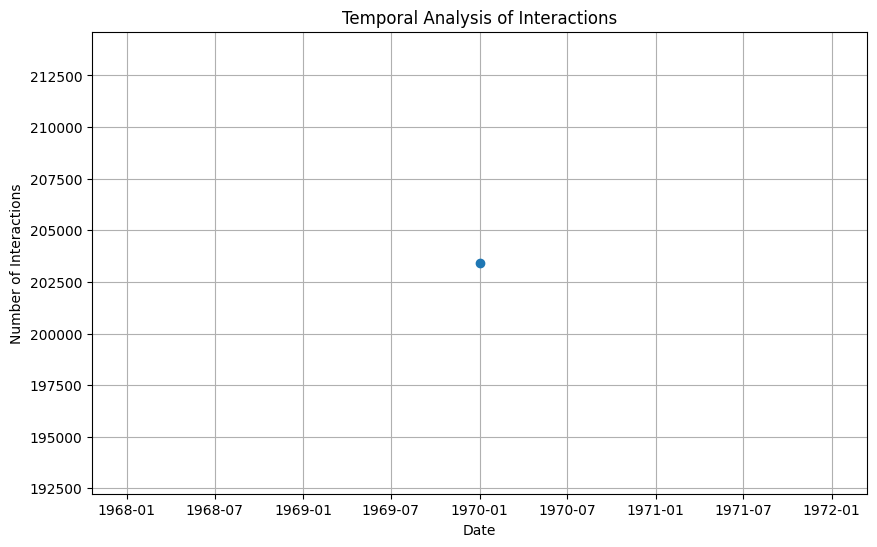

In [28]:
# Temporal Analysis
def temporal_analysis(tweets):
    tweets['date'] = tweets['created_at'].dt.date
    daily_interactions = tweets.groupby('date').size()
    plt.figure(figsize=(10, 6))
    daily_interactions.plot(kind='line', marker='o')
    plt.title("Temporal Analysis of Interactions")
    plt.xlabel("Date")
    plt.ylabel("Number of Interactions")
    plt.grid(True)
    plt.show()

temporal_analysis(tweets_df)

### Problem 2 

Prepare an infographics/presentation/report containing the most interesting conclusions from the analysis of the results of the previous task.

### Solution 